In [1]:
#du/dx - cos(x) = 0

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import math

rng = np.random.default_rng(seed=45)


In [2]:
n_wires=6
n_layers=4
dev = qml.device('default.qubit', wires=n_wires)


In [3]:
def plot_u():
    sample_y = np.sin(sample_x)

    plt.plot(sample_x, sample_y, 'bo-')
    plt.xlabel('x')
    plt.ylabel('sin(x)')
    plt.title('Plot of sin(x)')
    # plt.grid(True)
    plt.show()

In [4]:
def phi(x, j):  # Chebyshev
    return 2 * j * np.arccos(x)

def dphi1(x,j):
    return 2*j*(-1 / np.sqrt(1 - x ** 2))

def dphi2(x,j):
    return 2*j*(-x / ((1 - x ** 2) ** (3 / 2)))

In [5]:
@qml.qnode(dev)
def u_x(x,parameters):
    # feature map
    for j in range(n_wires):
        qml.RY(phi=phi(x,j+1),wires=j)
    # ansatz
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(dev.num_wires)) 
    # Cost function <Z>
    return qml.expval(qml.PauliZ(0))

# shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=n_wires)
# w = rng.random(size=shape)
# print(qml.draw(u_x)(0.1,w))

In [6]:


@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def du_x_helper(phi_x_vector,parameters):
    # feature map
    for j in range(n_wires):
        qml.RY(phi_x_vector[j],wires=j)
    # ansatz
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(dev.num_wires)) 
    # Cost function <Z>
    return qml.expval(qml.PauliZ(0))

         
def du_x(x,parameters):
    phi_x=['Nan']*n_wires
    dphi_x=['Nan']*n_wires
    for j in range(n_wires):
        phi_x[j] = phi(x,j)
        dphi_x[j] = dphi1(x,j)
    phi_x = np.array(phi_x,requires_grad=True)
    dphi_x = np.array(dphi_x)
    # parameters_nograd = np.array(parameters,requires_grad=False)
    grads=qml.grad(du_x_helper,argnum=0)(phi_x,parameters)   
    grad_dphi = grads*dphi_x 
    return 0.5*np.sum(grad_dphi)

        
# shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=n_wires)#TODO:// dynamic
# params = rng.random(size=shape)
# sample_x = np.linspace(0.1, 0.9, 10, endpoint=True)
# for x in sample_x:
#     print(du_x(x,parameters=params))

# raise Exception()
# shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=n_wires)#TODO:// dynamic
# params = rng.random(size=shape)
# print(params)
# print(qml.grad(du_x)(0.1,params))
# raise Exception('haha')

In [7]:
sample_x = np.linspace(0.1, 0.9, 15, endpoint=True)
sample_x

tensor([0.1       , 0.15714286, 0.21428571, 0.27142857, 0.32857143,
        0.38571429, 0.44285714, 0.5       , 0.55714286, 0.61428571,
        0.67142857, 0.72857143, 0.78571429, 0.84285714, 0.9       ], requires_grad=True)

In [8]:
def calculate_loss_boundry(parameters,err="MSE"):
    #boundry for u(x)=sin(x), u(0)=0, u(pi/2)=1
    x = [0,1]
    u = [0,0.84]
    u_predict=[0,0]
    error = None
    for i in range(len(x)):
        u_predict[i]=u_x(x=x[i],parameters=parameters)

    if err=="MSE":
        #MSE
        error = np.mean((np.array(u_predict) - np.array(u))**2)
    else:
        raise Exception('Not implemented yet')
    return error
# calculate_loss_boundry(weights)

In [9]:
np.cos(sample_x)

tensor([0.99500417, 0.98767845, 0.97712854, 0.96338887, 0.9465043 ,
        0.92652994, 0.903531  , 0.87758256, 0.84876933, 0.81718535,
        0.78293374, 0.74612631, 0.70688321, 0.66533255, 0.62160997], requires_grad=True)

In [10]:
def calculate_loss_interior(parameters,err="MSE"):
    # sample_ux = np.sin(sample_x)
    du_x_res=np.array([0.0]*len(sample_x))
    rhs = np.zeros(len(sample_x))
    error = None
    for i in range(len(sample_x)):
        du_x_res[i]=du_x(x=sample_x[i],parameters=parameters)
    lhs = du_x_res-np.cos(sample_x)
    if err=="MSE":
        #MSE
        error = np.mean((lhs - rhs)**2)
    else:
        raise Exception('Not implemented yet')
    return error

# shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=n_wires)#TODO:// dynamic
# params = rng.random(size=shape)
# calculate_loss_interior(params)

In [11]:


def loss_func(params,l_b=0.2,l_i=0.8):
    
    loss= l_b*calculate_loss_boundry(params)+l_i*calculate_loss_interior(params)
    return loss

In [12]:
def plot_u_predict(params):
    
    sample_u = np.sin(sample_x)
    sample_u_predict = []
    for x in sample_x:
        sample_u_predict.append(u_x(x, params))  # Assuming u_x is defined elsewhere

    plt.plot(sample_x, sample_u, 'bo-', label='Actual')
    plt.plot(sample_x, sample_u_predict, 'r*-', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('sin(x)')
    plt.title('Plot of sin(x)')
    plt.legend()
    plt.grid(True)
    plt.show()
# plot_u_predict()

0
Step  0 
 params =  None  loss =  0.4593036441247459


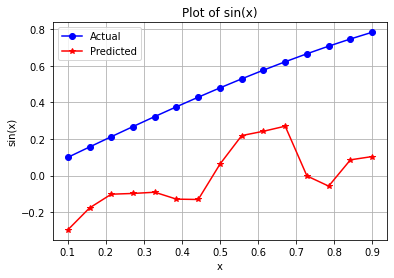

1
2
3
4
5
6
7
8
9
10
Step  10 
 params =  None  loss =  0.664472873642018


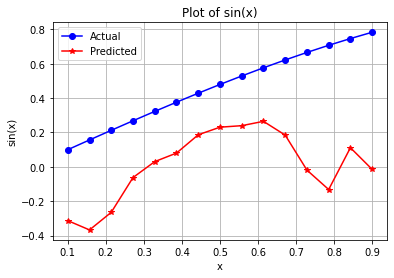

11
12
13
14
15
16
17
18
19
20
Step  20 
 params =  None  loss =  1.1712492961045664


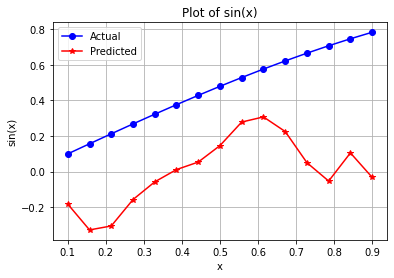

21
22
23
24
25
26
27
28
29
30
Step  30 
 params =  None  loss =  1.3679028441623908


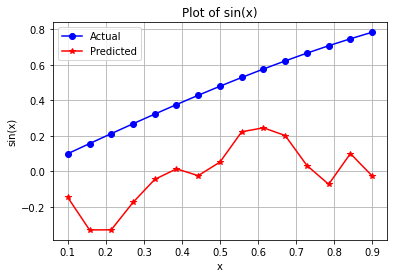

31
32
33
34
35
36
37
38
39
40
Step  40 
 params =  None  loss =  1.3589177363417988


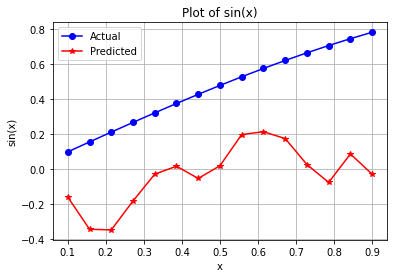

41
42
43
44
45
46
47
48
49
50
Step  50 
 params =  None  loss =  1.3550686679938488


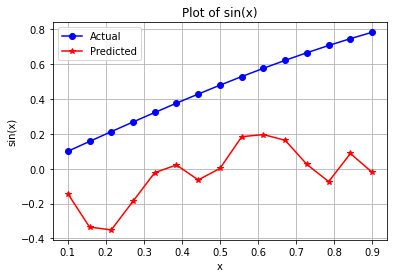

51
52
53
54
55
56
57
58
59
60
Step  60 
 params =  None  loss =  1.3516539325698071


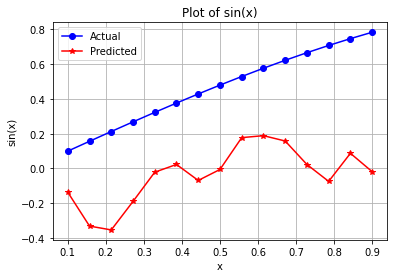

61
62
63
64
65
66
67
68
69
70
Step  70 
 params =  None  loss =  1.3504607966749036


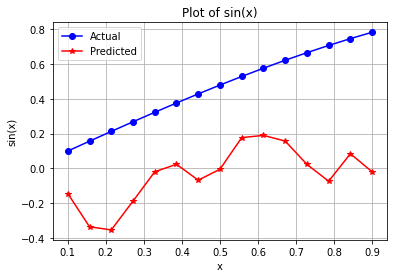

71
72
73
74
75
76
77
78
79
80
Step  80 
 params =  None  loss =  1.3464577969569462


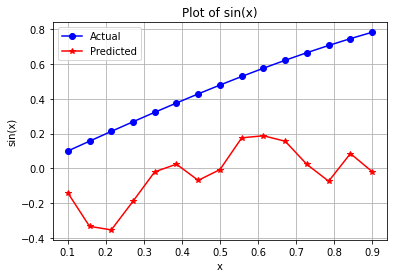

81
82
83
84
85
86
87
88
89
90
Step  90 
 params =  None  loss =  1.348724610699955


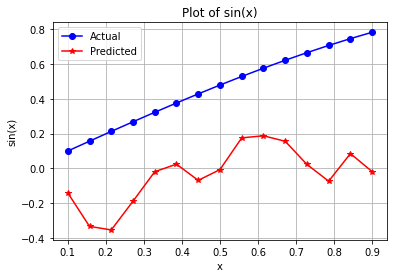

91
92
93
94
95
96
97
98
99
100
Step  100 
 params =  None  loss =  1.347591500896229


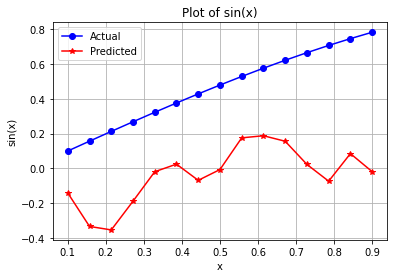

101
102
103
104
105
106
107
108
109
110
Step  110 
 params =  None  loss =  1.347974650761033


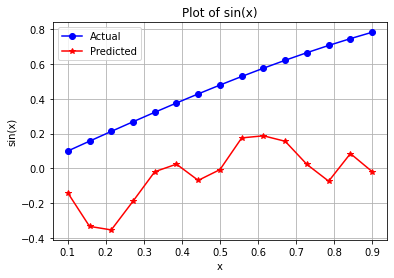

111
112
113
114
115
116
117
118
119
120
Step  120 
 params =  None  loss =  1.3477906852514754


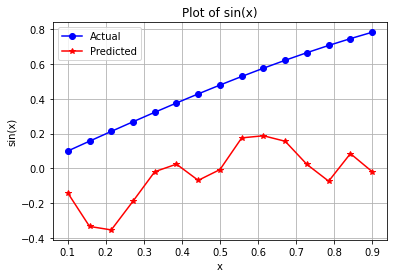

121
122
123
124
125
126
127
128
129
130
Step  130 
 params =  None  loss =  1.3479066719120367


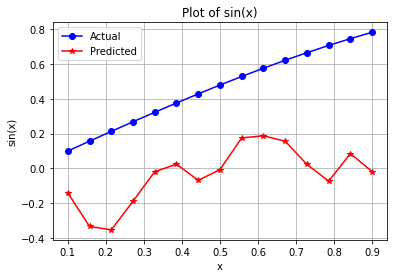

131
132
133
134
135
136
137
138
139
140
Step  140 
 params =  None  loss =  1.3478558780907661


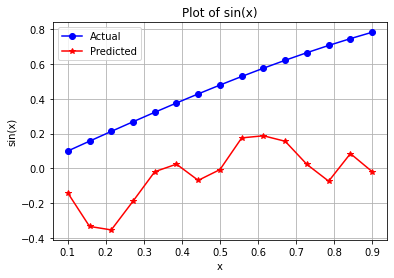

141
142
143
144
145
146
147
148
149
150
Step  150 
 params =  None  loss =  1.3478348825427846


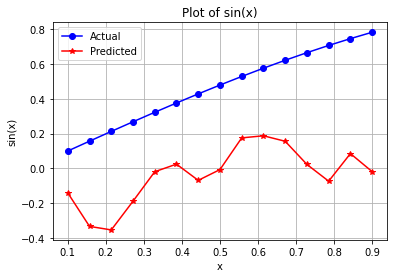

151
152
153
154
155
156
157
158
159
160
Step  160 
 params =  None  loss =  1.3478963906240768


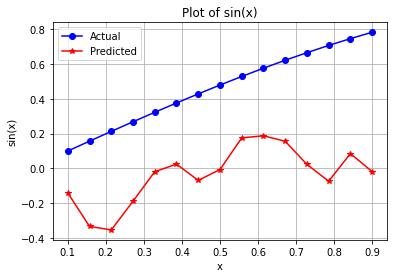

161
162
163
164


KeyboardInterrupt: 

In [13]:
shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)#TODO:// dynamic
params = rng.random(size=shape)
# opt = qml.GradientDescentOptimizer() #TODO:// ADAM
opt = qml.AdamOptimizer(0.05, beta1=0.9, beta2=0.999)
for i in range(400):
    params, loss = opt.step_and_cost(loss_func, params)
    print(i)
    if i%10==0:
        print("Step ", i, "\n params = ", None,' loss = ',loss)
        plot_u_predict(params)
        

In [ ]:
print(params)
np.save("optimized_params_sin_prime.npy", params)
# loaded_params = np.load("optimized_params.npy")
# print("Loaded parameters:", loaded_params)

[[[ 0.77395605 -0.02690195  0.06878156]
  [ 0.23583767 -0.71508796  1.27560438]
  [ 0.09358354  0.77753127 -0.06614804]
  [ 0.19918381  1.27188279  0.45109944]
  [ 1.37592054  0.63255447  0.10190661]
  [ 0.04285918  0.17395651  0.30700291]]

 [[ 1.58352352  1.60506722  2.23837551]
  [ 0.71211043  1.23509285  0.61882985]
  [ 1.33904891  1.31942187 -0.50424935]
  [ 0.63697956  0.39852332  0.24006298]
  [ 1.00264411  0.69553391 -0.42386772]
  [-0.07396663  1.42778316  0.01266967]]

 [[-0.53836647  1.50436477 -0.08666687]
  [ 0.66981399  0.43715192  0.8326782 ]
  [ 0.41489892 -0.54840745  1.06235261]
  [-0.14697371  1.28598805  0.34352156]
  [ 0.6824955   0.13975248  0.1999082 ]
  [ 0.00543036  1.56591066  1.54728759]]

 [[ 0.76035884  0.78968253  0.45891578]
  [ 0.5687412   0.139797    0.11453007]
  [ 1.55083969  0.84712055  0.56523611]
  [ 0.76499886  0.63471832  0.5535794 ]
  [ 0.55920716  0.3039501   0.03081783]
  [ 0.43671739  0.21458467  0.40852864]]]
Loaded parameters: [[[ 0.7739560

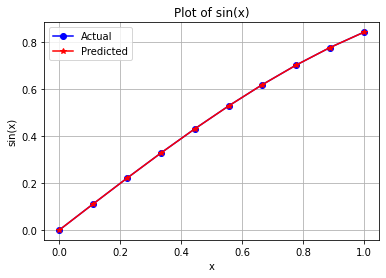

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
0.28595222510483553
0.2758089532187245


In [ ]:
plot_u_predict(loaded_params)
sample_x = np.linspace(0, 1, 10, endpoint=True)
print(sample_x)
x=0.29
print(np.sin(x))
print(u_x(parameters=loaded_params,x=x))
